## Fair phenotyping demo
To assess whether a computational labelling function is necessarily fair given protected attributes, we intend to compute fairness metrics (equalized odds, etc) for the outputs of any given labeler. Because true labels (of whether a patient had a particular disease) are subject to differences in disease diagnosis criteria, we use multiple phenotype definitions, similar to [this paper](https://proceedings.neurips.cc//paper/2020/file/03593ce517feac573fdaafa6dcedef61-Paper.pdf). Following the logic of the aforementioned paper, if the **majority** of phenotypes classify a given patient at a given timestep as having Crohn's, we use that as our best proxy of a true label.

For the purposes of this demo, for Crohn's phenotypes I used:
1.  The OHDSI HERA-based [Crohn's disease for first time with no history (Thirumurthi)](https://github.com/ohdsi-studies/HERACharacterization/blob/master/inst/cohorts/201606003.json). This cohort requires 365 days of prior observation. On Radak-W, this is cohort 22222.
2.  Another Thirumurthi definition, except this time from the 2010 paper. This one is 22223.
3.  An Ananthakrisnan 2013 definition is 22224.
4.  The Stepaniuk definition is 22225.

In [1]:
from getpass import getpass
import os
from keyrings.cryptfile.cryptfile import CryptFileKeyring

In [2]:
kr = CryptFileKeyring()
kr.keyring_key = os.getenv("KEYRING_CRYPTFILE_PASSWORD") or getpass()

In [3]:
import keyring
import pandas as pd
import pyodbc

In [4]:
keyring.set_keyring(kr)

In [5]:
# Connecting to the OMOP instance
connection_string = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=#######;'
    'DATABASE=ohdsi_cumc_2021q1r2;'
    'UID=#####;'
    f"PWD={keyring.get_password('#####', '#####')};"
)

In [6]:
conn = pyodbc.connect(connection_string)

In [7]:
# todo - merge all into one table with separate cohort_ids
sql_query_string = 'select * from ohdsi_cumc_2021q1r2.results.crohns_example'

subset_df = pd.io.sql.read_sql(sql_query_string, conn)

In [8]:
len(subset_df)

26729

In [9]:
subset_df.cohort_definition_id.unique()

array([22222, 22223, 22224, 22226, 22225])

In [10]:
for i in range(22222, 22227):
    print(len(subset_df[subset_df.cohort_definition_id == i]))

7308
3257
12935
1075
2154


In [11]:
# For each of these existing data [33333, 33334, 33335] let's get a sense of the overlap
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [12]:
%matplotlib inline

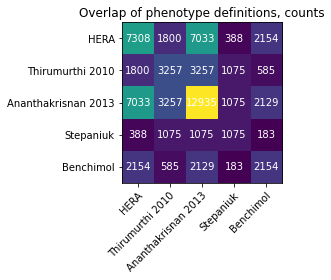

In [13]:
y_axis = ["HERA", "Thirumurthi 2010", "Ananthakrisnan 2013", "Stepaniuk", "Benchimol"]
x_axis = ["HERA", "Thirumurthi 2010", "Ananthakrisnan 2013", "Stepaniuk", "Benchimol"]

values = np.zeros((5, 5), dtype=int)
for i, cohort_id_i in enumerate([22222, 22223, 22224, 22225, 22226]):
    for j, cohort_id_j in enumerate([22222, 22223, 22224, 22225, 22226]):
        A = set(subset_df[subset_df.cohort_definition_id == cohort_id_i].subject_id.unique())
        B = set(subset_df[subset_df.cohort_definition_id == cohort_id_j].subject_id.unique())
        values[i][j] = len(A.intersection(B))

fig, ax = plt.subplots()
im = ax.imshow(values)

# We want to show all ticks...
ax.set_xticks(np.arange(len(x_axis)))
ax.set_yticks(np.arange(len(y_axis)))
# ... and label them with the respective list entries
ax.set_xticklabels(x_axis)
ax.set_yticklabels(y_axis)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(x_axis)):
    for j in range(len(y_axis)):
        text = ax.text(j, i, values[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Overlap of phenotype definitions, counts")
fig.tight_layout()
plt.show()

In [14]:
# Let's just use all definitions - HERA, Thirumurthi 2010, Ananthakrisnan 2013, Stepaniuk, Benchimol
A = set(subset_df[subset_df.cohort_definition_id == 22222].subject_id.unique())
B = set(subset_df[subset_df.cohort_definition_id == 22223].subject_id.unique())
C = set(subset_df[subset_df.cohort_definition_id == 22224].subject_id.unique())
D = set(subset_df[subset_df.cohort_definition_id == 22225].subject_id.unique())
E = set(subset_df[subset_df.cohort_definition_id == 22226].subject_id.unique())
shared = A.intersection(B).intersection(C).intersection(D).intersection(E)

In [15]:
len(shared)

183

In [17]:
len(list(A))

7308

In [18]:
# # Let's pull the demographic data for patients in A, B, and C
sql_query_string = 'select * from ohdsi_cumc_2021q1r2.dbo.person where person_id in (' + ', '.join([str(x) for x in list(A)]) + ')'
demo_A = pd.io.sql.read_sql(sql_query_string, conn)

# Let's pull the demographic data for patients in B, and C
sql_query_string = 'select * from ohdsi_cumc_2021q1r2.dbo.person where person_id in (' + ', '.join([str(x) for x in list(B)]) + ')'
demo_B = pd.io.sql.read_sql(sql_query_string, conn)

sql_query_string = 'select * from ohdsi_cumc_2021q1r2.dbo.person where person_id in (' + ', '.join([str(x) for x in list(C)]) + ')'
demo_C = pd.io.sql.read_sql(sql_query_string, conn)

sql_query_string = 'select * from ohdsi_cumc_2021q1r2.dbo.person where person_id in (' + ', '.join([str(x) for x in list(D)]) + ')'
demo_D = pd.io.sql.read_sql(sql_query_string, conn)

sql_query_string = 'select * from ohdsi_cumc_2021q1r2.dbo.person where person_id in (' + ', '.join([str(x) for x in list(E)]) + ')'
demo_E = pd.io.sql.read_sql(sql_query_string, conn)

In [19]:
# sql_query_string = 'select * from ohdsi_cumc_2021q1r2.results.diabetes_demographics where cohort_definition_id = 33333'
# demo_A = pd.io.sql.read_sql(sql_query_string, conn)

# sql_query_string = 'select * from ohdsi_cumc_2021q1r2.results.diabetes_demographics where cohort_definition_id = 33334'
# demo_B = pd.io.sql.read_sql(sql_query_string, conn)

# sql_query_string = 'select * from ohdsi_cumc_2021q1r2.results.diabetes_demographics where cohort_definition_id = 33335'
# demo_C = pd.io.sql.read_sql(sql_query_string, conn)

In [20]:
# Let's just grab everybody from the server
sql_query_string = "select person_id, gender_concept_id, race_concept_id, ethnicity_concept_id from ohdsi_cumc_2021q1r2.dbo.person"
everybody = pd.io.sql.read_sql(sql_query_string, conn)

In [21]:
# We also need patients that are _not_ Crohn's patients. For a fair comparison,
# I chose patients who also had at least 365 days of continuous observation.

sql_query_string = "select * from ohdsi_cumc_2021q1r2.results.oneyearprior"
oneyearprior = pd.io.sql.read_sql(sql_query_string, conn)

In [22]:
# oneyear_ids = set(oneyearprior.subject_id.unique())
# negative_ids = oneyear_ids - A - B - C
all_ids = set(everybody.person_id.unique())
negative_ids = all_ids - A - B - C - D - E

In [23]:
# It's not perfect math, but this is a proof of concept
len(A.union(B).union(C).union(D).union(E)), len(all_ids), len(negative_ids)

(13210, 6747059, 6733849)

In [24]:
# 8507 = Men, 8532 = Women
len(everybody[everybody.gender_concept_id == 8507].person_id.unique()), len(everybody[everybody.gender_concept_id == 8532].person_id.unique())

(2971591, 3758402)

In [25]:
# Let's pull the demographic data for negative_ids patients
# I did this in SQL to be faster.

# # select count(t2.gender_concept_id)
# # from ohdsi_cumc_2021q1r2.dbo.person t2
# #     inner join ohdsi_cumc_2021q1r2.results.oneyearprior t1
# #         on t1.subject_id = t2.person_id
# # where not exists ( select null
# #                    from ohdsi_cumc_2021q1r2.results.crohns_example t3
# #                    WHERE t3.subject_id = t2.person_id ) and
# # t2.gender_concept_id = 8507
# # t2.gender_concept_id = 8532

# women_negative_count = 160491
# men_negative_count = 86998

In [26]:
# select count(t2.gender_concept_id)
# from ohdsi_cumc_2021q1r2.dbo.person t2
#     inner join ohdsi_cumc_2021q1r2.results.oneyearprior t1
#         on t1.subject_id = t2.person_id
# where t2.gender_concept_id = 8507

# men_total_1year = 87495
# women_total_1year = 161133
men_total = 2971591
women_total = 3758402

In [27]:
# Let's assess the demographic parity for A, B, and C
#
# Quoting the PAKDD lecture, the fundamental idea is that the proportion of each protected class 
# should receive the positive (and negative) outcomes at equal rates. 

# Let class 0 be men (8507), class 1 be women (8532)

diffs = []

for phenotype in [demo_A, demo_B, demo_C, demo_D, demo_E]:
    class_0_prop_outcome = len(phenotype[phenotype.gender_concept_id == 8507]) / (men_total)
    class_1_prop_outcome = len(phenotype[phenotype.gender_concept_id == 8532]) / (women_total)
    print('Men: ' + str(class_0_prop_outcome))
    print('Women: ' + str(class_1_prop_outcome))
    print('Diff: ' + str(class_1_prop_outcome - class_0_prop_outcome))
    diffs.append(class_1_prop_outcome - class_0_prop_outcome)

Men: 0.001084267653253762
Women: 0.001086898101906076
Diff: 2.6304486523140783e-06
Men: 0.0005340573450383986
Women: 0.00044433777972659655
Diff: -8.971956531180202e-05
Men: 0.0020608488853277587
Women: 0.001811674216861315
Diff: -0.00024917466846644367
Men: 0.00018273039593941426
Women: 0.00014154952024823315
Diff: -4.118087569118112e-05
Men: 0.00034493306784143577
Women: 0.00030039362473732186
Diff: -4.453944310411391e-05


Text(0.5, 0, 'Phenotype algorithm')

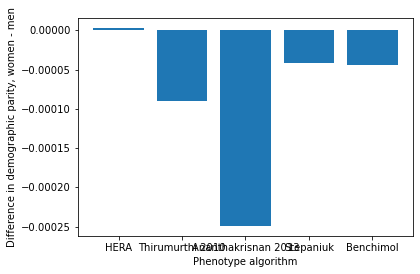

In [28]:
plt.bar(["HERA", "Thirumurthi 2010", "Ananthakrisnan 2013", "Stepaniuk", "Benchimol"], diffs)
plt.ylabel('Difference in demographic parity, women - men')
plt.xlabel('Phenotype algorithm')

In [29]:
# Let's assess the equality of opportunity for A, B, C, D, E
#
# Again quoting the PAKDD lecture, equalized odds is when the predicted output of the model is independent of
# the protected attribute conditional on the data. This definition is restrictive because it’s hard to
# calculate conditional independence, so there is instead a relaxed version
# (also known as the Equality of Opportunity) which is used instead.
# We need the true definitions. In this case, the true cases are majority class for the phenotypes,
# or the set of patients that are in:
# ABC, ABD, ABE
# ACD, ACE,
# ADE
# BCD, BCE
# BDE
# CDE

ABC = set(A.intersection(B).intersection(C))
ABD = set(A.intersection(B).intersection(D))
ABE = set(A.intersection(B).intersection(E))
ACD = set(A.intersection(C).intersection(D))
ACE = set(A.intersection(C).intersection(E))
ADE = set(A.intersection(D).intersection(E))
BCD = set(B.intersection(C).intersection(D))
BCE = set(B.intersection(C).intersection(E))
BDE = set(B.intersection(D).intersection(E))
CDE = set(C.intersection(D).intersection(E))
Y  = set(ABC.union(ABD).union(ABE).union(ABE).union(ACD).union(ACE).union(ADE).union(BCD).union(BCE).union(BDE).union(CDE))

In [30]:
len(Y)

4031

In [31]:
full_df = pd.concat((demo_A[demo_A.person_id.isin(Y)], demo_B[demo_B.person_id.isin(Y)], demo_C[demo_C.person_id.isin(Y)], demo_D[demo_D.person_id.isin(Y)], demo_E[demo_E.person_id.isin(Y)])).drop_duplicates()

In [32]:
len(phenotype[(phenotype.gender_concept_id == 8507) & (phenotype.person_id.isin(Y))])

1019

In [33]:
len(full_df[full_df.gender_concept_id == 8507])

1922

In [34]:
# Let class 0 be men (8507), class 1 be women (8532)

diffs = []

for phenotype in [demo_A, demo_B, demo_C, demo_D, demo_E]:
    class_0_eqq_opp = len(phenotype[(phenotype.gender_concept_id == 8507) & (phenotype.person_id.isin(Y))]) / len(full_df[full_df.gender_concept_id == 8507])
    class_1_eqq_opp = len(phenotype[(phenotype.gender_concept_id == 8532) & (phenotype.person_id.isin(Y))]) / len(full_df[full_df.gender_concept_id == 8532])
    print('Men: ' + str(class_0_eqq_opp))
    print('Women: ' + str(class_1_eqq_opp))
    print('Diff: ' + str(class_1_eqq_opp - class_0_eqq_opp))
    diffs.append(class_1_eqq_opp - class_0_eqq_opp)

Men: 0.8090530697190427
Women: 0.8482693219535324
Diff: 0.03921625223448977
Men: 0.6170655567117586
Women: 0.6168800379326695
Diff: -0.00018551877908901115
Men: 1.0
Women: 1.0
Diff: 0.0
Men: 0.28251821019771073
Women: 0.25225225225225223
Diff: -0.0302659579454585
Men: 0.5301768990634755
Women: 0.5263157894736842
Diff: -0.003861109589791356


Text(0.5, 0, 'Phenotype algorithm')

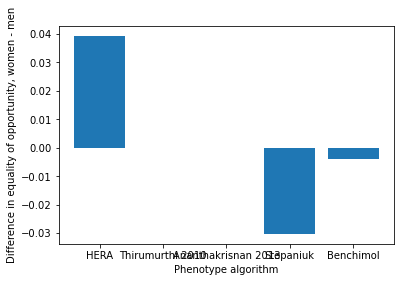

In [35]:
plt.bar(["HERA", "Thirumurthi 2010", "Ananthakrisnan 2013", "Stepaniuk", "Benchimol"], diffs)
plt.ylabel('Difference in equality of opportunity, women - men')
plt.xlabel('Phenotype algorithm')

In [36]:
# Again quoting the PAKDD lecture, predictive rate parity (or sufficiency) means that the true label
# is independent of the protected attribute conditional on the predicted outputs.

diffs = []

for phenotype in [demo_A, demo_B, demo_C, demo_D, demo_E]:
    class_0_prp = len(phenotype[(phenotype.gender_concept_id == 8507) & (phenotype.person_id.isin(Y))]) / len(phenotype[phenotype.gender_concept_id == 8507])
    class_1_prp = len(phenotype[(phenotype.gender_concept_id == 8532) & (phenotype.person_id.isin(Y))]) / len(phenotype[phenotype.gender_concept_id == 8532])
    print('Men: ' + str(class_0_prp))
    print('Women: ' + str(class_1_prp))
    print('Diff: ' + str(class_1_prp - class_0_prp))
    diffs.append(class_1_prp - class_0_prp)

Men: 0.4826194909993793
Women: 0.4379436964504284
Diff: -0.044675794548950876
Men: 0.7473219911783239
Women: 0.7790419161676647
Diff: 0.03171992498934084
Men: 0.31384715871979096
Women: 0.3097371126450286
Diff: -0.004110046074762341
Men: 1.0
Women: 1.0
Diff: 0.0
Men: 0.9941463414634146
Women: 0.983170947741364
Diff: -0.010975393722050586


Text(0, 0.5, 'Phenotype algorithm')

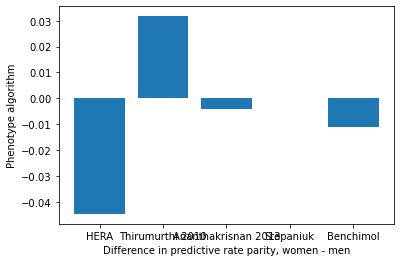

In [37]:
plt.bar(["HERA", "Thirumurthi 2010", "Ananthakrisnan 2013", "Stepaniuk", "Benchimol"], diffs)
plt.xlabel('Difference in predictive rate parity, women - men')
plt.ylabel('Phenotype algorithm')

In [38]:
from statsmodels.stats.proportion import proportions_ztest

In [59]:
cutoff = 0.05

In [60]:
# Let's assess the demographic parity for A, B, and C
#
# Quoting the PAKDD lecture, the fundamental idea is that the proportion of each protected class 
# should receive the positive (and negative) outcomes at equal rates. 

# Let class 0 be men (8507), class 1 be women (8532)

diffs_dp = []
all_vals_dp = []
pvals_dp = []


for phenotype in [demo_A, demo_B, demo_C, demo_D, demo_E]:
    class_0_prop_outcome = len(phenotype[phenotype.gender_concept_id == 8507]) / (men_total)
    class_1_prop_outcome = len(phenotype[phenotype.gender_concept_id == 8532]) / (women_total)
    print('Men: ' + str(class_0_prop_outcome))
    print('Women: ' + str(class_1_prop_outcome))
    print('Diff: ' + str(class_1_prop_outcome - class_0_prop_outcome))
    diffs_dp.append(class_1_prop_outcome - class_0_prop_outcome)
    all_vals_dp.append((class_1_prop_outcome, class_0_prop_outcome))
    
    count = np.array([len(phenotype[phenotype.gender_concept_id == 8507]), len(phenotype[phenotype.gender_concept_id == 8532])])
    nobs = np.array([men_total, women_total])
    stat, pval = proportions_ztest(count, nobs)
    pvals_dp.append(pval)

Men: 0.001084267653253762
Women: 0.001086898101906076
Diff: 2.6304486523140783e-06
Men: 0.0005340573450383986
Women: 0.00044433777972659655
Diff: -8.971956531180202e-05
Men: 0.0020608488853277587
Women: 0.001811674216861315
Diff: -0.00024917466846644367
Men: 0.00018273039593941426
Women: 0.00014154952024823315
Diff: -4.118087569118112e-05
Men: 0.00034493306784143577
Women: 0.00030039362473732186
Diff: -4.453944310411391e-05


In [61]:
import seaborn as sns

In [62]:
# ss = pd.DataFrame(data={'Crohn\'s phenotypes': ['Silver Standard'], 
#                          'women': [women_silver], 
#                          'men': [men_silver]})

# ss1 = pd.melt(ss, id_vars = "Crohn\'s phenotypes", var_name='gender', value_name='Prevalence (per 100,000 patients)')


In [63]:
# # https://stackoverflow.com/questions/54389331/adjust-different-transparency-for-different-class-in-seaborn-scatter-plot
# category_order = ["Silver Standard", "HERA", "Thirumurthi\n(2010)", "Ananthakrisnan\n(2013)", "Stepaniuk\n(2015)", "Benchimol\n(2014)"]

# sns.set(style = "ticks")
# g = sns.catplot(x = 'Crohn\'s phenotypes', y='Prevalence (per 100,000 patients)', 
#                hue = 'gender', data=dfs1, kind='bar', order = category_order,
#                palette=sns.color_palette(['#8700f9', '#00c4aa']), alpha = 0.7, legend=False)

# sns.catplot(x = 'Crohn\'s phenotypes', y='Prevalence (per 100,000 patients)', 
#                hue = 'gender', data=ss1, kind='bar', order = category_order,
#                palette=sns.color_palette(['#8700f9', '#00c4aa']), alpha = 0.35, legend=False)

# sns.despine()

# g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
# g.fig.suptitle('Demographic Parity (Prevalence Difference)')


# # plt.text(0, 110, "$\Delta = $" + str(np.round(diffs_dp[0] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# # plt.text(1, 35, "$\Delta = $" + str(np.round(diffs_dp[1] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# # plt.text(2, 208, "$\Delta = $" + str(np.round(diffs_dp[2] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# # plt.text(3, 21, "$\Delta = $" + str(np.round(diffs_dp[3] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# # plt.text(4, 38, "$\Delta = $" + str(np.round(diffs_dp[4] * 100000, 2)), horizontalalignment='center', size='medium', color='black')

# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(10, 6)

In [203]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

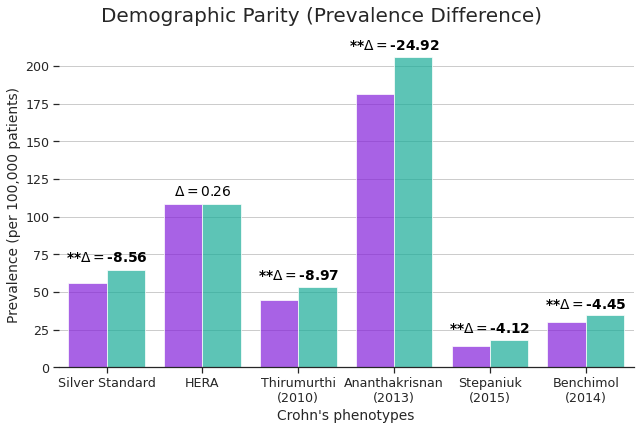

In [204]:
# #8700f9 women
# #00c4aa men

# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'Crohn\'s phenotypes': ["HERA", "Thirumurthi\n(2010)", "Ananthakrisnan\n(2013)", "Stepaniuk\n(2015)", "Benchimol\n(2014)"], 
                         'women': [x[0] * 100000 for x in all_vals_dp], 
                         'men': [x[1] * 100000 for x in all_vals_dp]})

dfs1 = pd.melt(dfs, id_vars = "Crohn\'s phenotypes", var_name='gender', value_name='Prevalence (per 100,000 patients)')

men_silver = len(full_df[full_df.gender_concept_id == 8507].person_id.unique()) / men_total * 100000
women_silver = len(full_df[full_df.gender_concept_id == 8532].person_id.unique()) / women_total * 100000

count = np.array([len(full_df[full_df.gender_concept_id == 8507].person_id.unique()), 
                  len(full_df[full_df.gender_concept_id == 8532].person_id.unique())])
nobs = np.array([men_total, women_total])
stat, pval_silver = proportions_ztest(count, nobs)


tmp = dfs1.append({'Crohn\'s phenotypes' : 'Silver Standard', 'gender' : 'women', 'Prevalence (per 100,000 patients)' : women_silver}, ignore_index=True)
tmp = tmp.append({'Crohn\'s phenotypes' : 'Silver Standard', 'gender' : 'men', 'Prevalence (per 100,000 patients)' : men_silver}, ignore_index=True)

category_order = ["Silver Standard", "HERA", "Thirumurthi\n(2010)", "Ananthakrisnan\n(2013)", "Stepaniuk\n(2015)", "Benchimol\n(2014)"]

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'Crohn\'s phenotypes', y='Prevalence (per 100,000 patients)', 
               hue = 'gender', data=tmp, kind='bar', order = category_order,
               palette=sns.color_palette(['#8700f9', '#00c4aa']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(women_silver, xmin=0, xmax=3, linestyle = '--', color = '#8700f9', label = 'silver standard (women)')
# plt.axhline(men_silver, xmin=0, xmax=3, linestyle = '--', color = '#00c4aa', label = 'silver standard (men)')

# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Demographic Parity (Prevalence Difference)')

if pval_silver < cutoff:
    plt.text(0, np.round(max(women_silver, men_silver), 0) + 5, "**$\Delta = $" + str(np.round(women_silver - men_silver, 2)), horizontalalignment='center', size='medium', color='black', weight='bold')
else:
    plt.text(0, np.round(max(women_silver, men_silver), 0) + 5, "$\Delta = $" + str(np.round(women_silver - men_silver, 2)), horizontalalignment='center', size='medium', color='black')
    
for i, ele in enumerate(all_vals_dp):
    part1 = "$\Delta = $" + str(np.round(diffs_dp[i] * 100000, 2))
    part2 = "$p = $" + str(np.round(pvals_dp[i], 4))
    full_str = part1 + '\n' + part2 
    if pvals_dp[i] < cutoff:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 5, '**' + part1, horizontalalignment='center', size='medium', color='black', weight='bold')
    else:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 5, part1, horizontalalignment='center', size='medium', color='black')
    # plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 5, , horizontalalignment='center', size='medium', color='black')

# plt.text(4, 70, "$\Delta = $" + str(np.round(women_silver - men_silver, 2)), horizontalalignment='center', size='medium', color='black')

# plt.text(0.03, all_vals_dp[0][1] * 100000, "]", horizontalalignment='center', size='medium', color='black', fontsize = 8)


# handles, labels = plt.gca().get_legend_handles_labels()

# #specify order of items in legend
# order = [2,3,0,1]

# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
#labels=["women","men", "women silver standard", "men silver standard"])

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

plt.savefig('../png/crohns_demographic_parity.png', dpi=300, bbox_inches = 'tight')
plt.show()
plt.close()


In [205]:
# Let class 0 be men (8507), class 1 be women (8532)

diffs_eqq_opp = []
all_vals_eqq_opp = []
pvals_eqq_opp = []

for phenotype in [demo_A, demo_B, demo_C, demo_D, demo_E]:
    class_0_nom = len(phenotype[(phenotype.gender_concept_id == 8507) & (phenotype.person_id.isin(Y))].person_id.unique())
    class_0_denom = len(full_df[full_df.gender_concept_id == 8507].person_id.unique())
    class_1_nom = len(phenotype[(phenotype.gender_concept_id == 8532) & (phenotype.person_id.isin(Y))].person_id.unique())
    class_1_denom = len(full_df[full_df.gender_concept_id == 8532].person_id.unique())
    class_0_eqq_opp = class_0_nom / class_0_denom
    class_1_eqq_opp = class_1_nom / class_1_denom
    print('Men: ' + str(class_0_eqq_opp))
    print('Women: ' + str(class_1_eqq_opp))
    print('Diff: ' + str(class_1_eqq_opp - class_0_eqq_opp))
    diffs_eqq_opp.append(class_1_eqq_opp - class_0_eqq_opp)
    all_vals_eqq_opp.append((class_1_eqq_opp, class_0_eqq_opp))
    
    count = np.array([class_0_nom, class_1_nom])
    nobs = np.array([class_0_denom, class_1_denom])
    stat, pval = proportions_ztest(count, nobs)
    pvals_eqq_opp.append(pval)

pvals_eqq_opp = np.nan_to_num(pvals_eqq_opp, nan=1)

Men: 0.8090530697190427
Women: 0.8482693219535324
Diff: 0.03921625223448977
Men: 0.6170655567117586
Women: 0.6168800379326695
Diff: -0.00018551877908901115
Men: 1.0
Women: 1.0
Diff: 0.0
Men: 0.28251821019771073
Women: 0.25225225225225223
Diff: -0.0302659579454585
Men: 0.5301768990634755
Women: 0.5263157894736842
Diff: -0.003861109589791356


/home/tys2108/anaconda3/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:788: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std


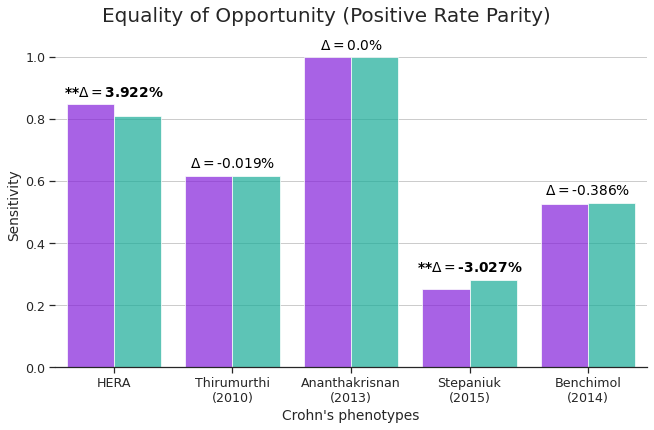

In [206]:
# #8700f9 women
# #00c4aa men
# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'Crohn\'s phenotypes': ["HERA", "Thirumurthi\n(2010)", "Ananthakrisnan\n(2013)", "Stepaniuk\n(2015)", "Benchimol\n(2014)"], 
                         'women': [x[0] for x in all_vals_eqq_opp], 
                         'men': [x[1] for x in all_vals_eqq_opp]})

dfs1 = pd.melt(dfs, id_vars = "Crohn\'s phenotypes", var_name='gender', value_name='Sensitivity')

men_silver = len(full_df[(full_df.gender_concept_id == 8507) & (full_df.person_id.isin(Y))].person_id.unique()) / len(full_df[full_df.gender_concept_id == 8507].person_id.unique())
women_silver = len(full_df[(full_df.gender_concept_id == 8532) & (full_df.person_id.isin(Y))].person_id.unique()) / len(full_df[full_df.gender_concept_id == 8532].person_id.unique())

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'Crohn\'s phenotypes', y='Sensitivity', 
               hue = 'gender', data=dfs1, kind='bar', 
               palette=sns.color_palette(['#8700f9', '#00c4aa']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(women_silver, xmin=0, xmax=3, linestyle = '--', color = '#8700f9', label = 'women silver standard', alpha = 0.8)
# plt.axhline(men_silver, xmin=0, xmax=3, linestyle = '--', color = '#00c4aa', label = 'men silver standard', alpha = 0.5)
# plt.axhline(1, xmin=0, xmax=3, linestyle = '-', color = 'black', label = 'silver standard', alpha = 0.5)
# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Equality of Opportunity (Positive Rate Parity)')

for i, ele in enumerate(all_vals_eqq_opp):
    part1 = "$\Delta = $" + str(np.round(diffs_eqq_opp[i] * 100, 3)) + '%'
    part2 = "$p = $" + str(np.round(pvals_eqq_opp[i], 4))
    full_str = part1 + '\n' + part2 
    if pvals_eqq_opp[i] < cutoff:
        plt.text(i, max(ele[0], ele[1]) + 0.025, '**' + part1, horizontalalignment='center', size='medium', color='black', weight='bold')
    else:
        plt.text(i, max(ele[0], ele[1]) + 0.025, part1, horizontalalignment='center', size='medium', color='black')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

# plt.text(0, 0.875, "$\Delta = $" + str(np.round(diffs_eqq_opp[0] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(1, 0.625, "$\Delta = $" + str(np.round(diffs_eqq_opp[1] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(2, 1.025, "$\Delta = $" + str(np.round(diffs_eqq_opp[2] * 100, 3))  + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(3, 0.3, "$\Delta = $" + str(np.round(diffs_eqq_opp[3] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(4, 0.55, "$\Delta = $" + str(np.round(diffs_eqq_opp[4] * 100, 3))  + '%', horizontalalignment='center', size='medium', color='black')

plt.savefig('../png/crohns_equality_opportunity.png', dpi=300, bbox_inches = 'tight')
plt.show()
plt.close()

In [207]:
# Again quoting the PAKDD lecture, predictive rate parity (or sufficiency) means that the true label
# is independent of the protected attribute conditional on the predicted outputs.

diffs_prp = []
all_vals_prp = []
pvals_prp = []

for phenotype in [demo_A, demo_B, demo_C, demo_D, demo_E]:
    class_0_nom = len(phenotype[(phenotype.gender_concept_id == 8507) & (phenotype.person_id.isin(Y))])
    class_0_denom = len(phenotype[phenotype.gender_concept_id == 8507])
    class_1_nom = len(phenotype[(phenotype.gender_concept_id == 8532) & (phenotype.person_id.isin(Y))])
    class_1_denom = len(phenotype[phenotype.gender_concept_id == 8532])
    class_0_prp =  class_0_nom / class_0_denom
    class_1_prp =  class_1_nom / class_1_denom
    print('Men: ' + str(class_0_prp))
    print('Women: ' + str(class_1_prp))
    print('Diff: ' + str(class_1_prp - class_0_prp))
    diffs_prp.append(class_1_prp - class_0_prp)
    all_vals_prp.append((class_1_prp, class_0_prp))
    
    count = np.array([class_0_nom, class_1_nom])
    nobs = np.array([class_0_denom, class_1_denom])
    stat, pval = proportions_ztest(count, nobs)
    pvals_prp.append(pval)

pvals_prp = np.nan_to_num(pvals_prp, nan=1)

Men: 0.4826194909993793
Women: 0.4379436964504284
Diff: -0.044675794548950876
Men: 0.7473219911783239
Women: 0.7790419161676647
Diff: 0.03171992498934084
Men: 0.31384715871979096
Women: 0.3097371126450286
Diff: -0.004110046074762341
Men: 1.0
Women: 1.0
Diff: 0.0
Men: 0.9941463414634146
Women: 0.983170947741364
Diff: -0.010975393722050586


/home/tys2108/anaconda3/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:788: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std


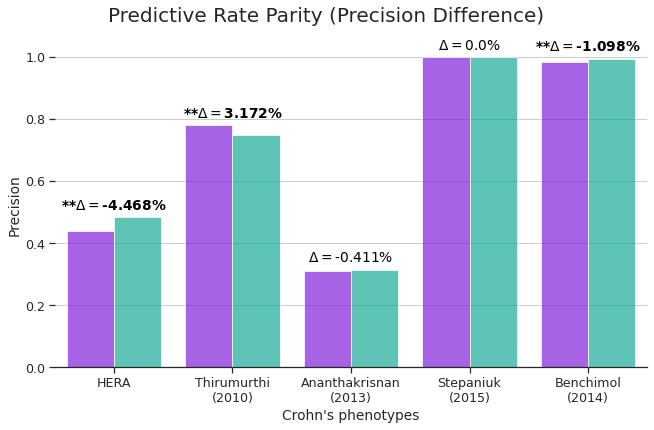

In [208]:
# #8700f9 women
# #00c4aa men
# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'Crohn\'s phenotypes': ["HERA", "Thirumurthi\n(2010)", "Ananthakrisnan\n(2013)", "Stepaniuk\n(2015)", "Benchimol\n(2014)"], 
                         'women': [x[0] for x in all_vals_prp], 
                         'men': [x[1] for x in all_vals_prp]})

dfs1 = pd.melt(dfs, id_vars = "Crohn\'s phenotypes", var_name='gender', value_name='Precision')

men_silver = len(full_df[(full_df.gender_concept_id == 8507) & (full_df.person_id.isin(Y))].person_id.unique()) / len(full_df[full_df.gender_concept_id == 8507].person_id.unique())
women_silver = len(full_df[(full_df.gender_concept_id == 8532) & (full_df.person_id.isin(Y))].person_id.unique()) / len(full_df[full_df.gender_concept_id == 8532].person_id.unique())

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'Crohn\'s phenotypes', y='Precision', 
               hue = 'gender', data=dfs1, kind='bar', 
               palette=sns.color_palette(['#8700f9', '#00c4aa']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(women_silver, xmin=0, xmax=3, linestyle = '--', color = '#8700f9', label = 'women silver standard', alpha = 0.8)
# plt.axhline(men_silver, xmin=0, xmax=3, linestyle = '--', color = '#00c4aa', label = 'men silver standard', alpha = 0.5)
# plt.axhline(1, xmin=0, xmax=3, linestyle = '-', color = 'black', label = 'silver standard', alpha = 0.5)
# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Predictive Rate Parity (Precision Difference)')

# plt.text(0, 0.475, "$\Delta = $" + str(np.round(diffs_prp[0] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(1, 0.8, "$\Delta = $" + str(np.round(diffs_prp[1] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(2, 0.3, "$\Delta = $" + str(np.round(diffs_prp[2] * 100, 3))  + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(3, 1.025, "$\Delta = $" + str(np.round(diffs_prp[3] * 100, 3))  + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(4, 1.025, "$\Delta = $" + str(np.round(diffs_prp[4] * 100, 3))  + '%', horizontalalignment='center', size='medium', color='black')

for i, ele in enumerate(all_vals_prp):
    part1 = "$\Delta = $" + str(np.round(diffs_prp[i] * 100, 3)) + '%'
    part2 = "$p = $" + str(np.round(pvals_prp[i], 4))
    full_str = part1 + '\n' + part2 
    if pvals_prp[i] < cutoff:
        plt.text(i, max(ele[0], ele[1]) + 0.025, '**' + part1, horizontalalignment='center', 
                 size='medium', color='black', weight='bold')
    else:
        plt.text(i, max(ele[0], ele[1]) + 0.025, part1, horizontalalignment='center', size='medium', color='black')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

plt.savefig('../png/crohns_pred_rate_parity.png', dpi=300, bbox_inches = 'tight')

# handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
# order = [2,3,0,1]

# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)

# plt.savefig('../png/t2dm_pred_rate_parity_legend.png', dpi=300, bbox_inches = 'tight')

#labels=["women","men", "women silver standard", "men silver standard"])

plt.show()

In [209]:
# fig, ax = plt.subplots()
# # ax.plot(range(10))

# fig.patch.set_visible(False)
# ax.axis('off')

# #specify order of items in legend
# order = [2,3,0,1]

# fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
# fig.savefig('../png/legend_women_men.png', dpi=300, bbox_inches = 'tight')

In [210]:
# race_source_value == WHITE
# race_source_concept_id == 4.0 [8527]

# VS

# race_source_value == BLACK OR AFRICAN AMERICAN
# race_source_concept_id == 3.0 [8516]

len(demo_A[demo_A.race_source_concept_id == 4.0]), len(demo_A[demo_A.race_source_concept_id == 3.00])

(3387, 510)

In [211]:
# 8527 = white, 8516 = Black
len(everybody[everybody.race_concept_id == 8527].person_id.unique()), len(everybody[everybody.race_concept_id == 8516].person_id.unique())

(1069661, 380926)

In [212]:
white_total = 1069661
Black_total = 380926

In [213]:
# Let's assess the demographic parity for A, B, and C across white vs Black
#
# Quoting the PAKDD lecture, the fundamental idea is that the proportion of each protected class 
# should receive the positive (and negative) outcomes at equal rates. 

# Let class 0 be white (4.0), class 1 be Black (3.0)

diffs_dp_race = []
all_vals_dp_race = []
p_vals_dp_race = []

for phenotype in [demo_A, demo_B, demo_C, demo_D, demo_E]:
    class_0_prop_outcome = len(phenotype[phenotype.race_source_concept_id == 4.0]) / (white_total)
    class_1_prop_outcome = len(phenotype[phenotype.race_source_concept_id == 3.0]) / (Black_total)
    diffs_dp_race.append(class_1_prop_outcome - class_0_prop_outcome)
    all_vals_dp_race.append((class_1_prop_outcome, class_0_prop_outcome))
    
    count = np.array([len(phenotype[phenotype.race_source_concept_id == 4.0]), 
                      len(phenotype[phenotype.race_source_concept_id == 3.0])])
    nobs = np.array([white_total, Black_total])
    stat, pval = proportions_ztest(count, nobs)
    p_vals_dp_race.append(pval)

p_vals_dp_race = np.nan_to_num(p_vals_dp_race, nan=1)

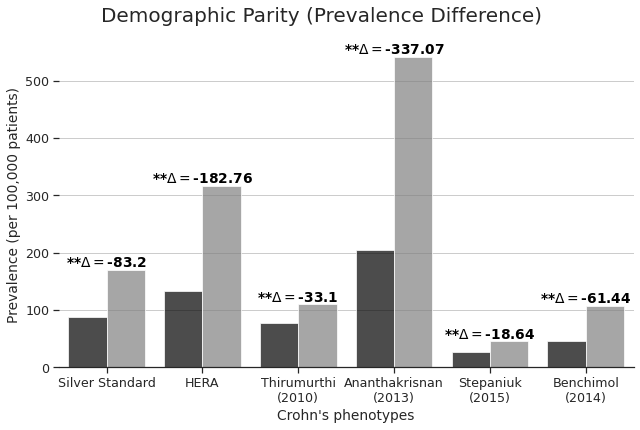

In [214]:
# #8700f9 women
# #00c4aa men
# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'Crohn\'s phenotypes': ["HERA", "Thirumurthi\n(2010)", "Ananthakrisnan\n(2013)", "Stepaniuk\n(2015)", "Benchimol\n(2014)"], 
                         'Black': [x[0] * 100000 for x in all_vals_dp_race], 
                         'white': [x[1] * 100000 for x in all_vals_dp_race]})

dfs1 = pd.melt(dfs, id_vars = "Crohn\'s phenotypes", var_name='race', value_name='Prevalence (per 100,000 patients)')

white_silver = len(full_df[full_df.race_source_concept_id == 4.0].person_id.unique()) / white_total * 100000
black_silver = len(full_df[full_df.race_source_concept_id == 3.0].person_id.unique()) / Black_total * 100000

count = np.array([len(full_df[full_df.race_source_concept_id == 4.0].person_id.unique()), 
                  len(full_df[full_df.race_source_concept_id == 3.0].person_id.unique())])
nobs = np.array([white_total, Black_total])
stat, pval_silver = proportions_ztest(count, nobs)


tmp = dfs1.append({'Crohn\'s phenotypes' : 'Silver Standard', 'race' : 'Black', 'Prevalence (per 100,000 patients)' : black_silver}, ignore_index=True)
tmp = tmp.append({'Crohn\'s phenotypes' : 'Silver Standard', 'race' : 'white', 'Prevalence (per 100,000 patients)' : white_silver}, ignore_index=True)

category_order = ["Silver Standard", "HERA", "Thirumurthi\n(2010)", "Ananthakrisnan\n(2013)", "Stepaniuk\n(2015)", "Benchimol\n(2014)"]

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'Crohn\'s phenotypes', y='Prevalence (per 100,000 patients)', 
               hue = 'race', data=tmp, kind='bar', order = category_order,
               palette=sns.color_palette(['black', 'grey']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(black_silver, xmin=0, xmax=3, linestyle = '--', color = 'black', label = 'silver standard (Black)')
# plt.axhline(white_silver, xmin=0, xmax=3, linestyle = '--', color = 'grey', label = 'silver standard (white)')

# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Demographic Parity (Prevalence Difference)')


# plt.text(0, 320, "$\Delta = $" + str(np.round(diffs_dp_race[0] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(1, 110, "$\Delta = $" + str(np.round(diffs_dp_race[1] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(2, 575, "$\Delta = $" + str(np.round(diffs_dp_race[2] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(3, 75, "$\Delta = $" + str(np.round(diffs_dp_race[3] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(4, 105, "$\Delta = $" + str(np.round(diffs_dp_race[4] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(4, 200, "$\Delta = $" + str(np.round(black_silver - white_silver, 2)), horizontalalignment='center', size='medium', color='black')

# plt.text(0.03, all_vals_dp[0][1] * 100000, "]", horizontalalignment='center', size='medium', color='black', fontsize = 8)


# handles, labels = plt.gca().get_legend_handles_labels()

# #specify order of items in legend
# order = [2,3,0,1]

# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
#labels=["women","men", "women silver standard", "men silver standard"])

if pval_silver < cutoff:
    plt.text(0, np.round(max(black_silver, white_silver), 0) + 5, "**$\Delta = $" + str(np.round(black_silver - white_silver, 2)), horizontalalignment='center', size='medium', color='black', weight='bold')
else:
    plt.text(0, np.round(max(black_silver, white_silver), 0) + 5, "$\Delta = $" + str(np.round(black_silver - white_silver, 2)), horizontalalignment='center', size='medium', color='black')
    
for i, ele in enumerate(all_vals_dp_race):
    part1 = "$\Delta = $" + str(np.round(diffs_dp_race[i] * 100000, 2))
    part2 = "$p = $" + str(np.round(p_vals_dp_race[i], 4))
    full_str = part1 + '\n' + part2 
    if p_vals_dp_race[i] < cutoff:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 5, '**' + part1, horizontalalignment='center', size='medium', color='black', weight='bold')
    else:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 5, part1, horizontalalignment='center', size='medium', color='black')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

plt.savefig('../png/crohns_demographic_parity_race.png', dpi=300, bbox_inches = 'tight')
plt.show()


In [215]:
# Let class 0 be white, class 1 be black

diffs_eqq_opp_race = []
all_vals_eqq_opp_race = []
pvals_eqq_opp_race = []

for phenotype in [demo_A, demo_B, demo_C, demo_D, demo_E]:
    class_0_eqq_opp = len(phenotype[(phenotype.race_source_concept_id == 4.0) & (phenotype.person_id.isin(Y))].person_id.unique()) / len(full_df[full_df.race_source_concept_id == 4.0].person_id.unique())
    class_1_eqq_opp = len(phenotype[(phenotype.race_source_concept_id == 3.0) & (phenotype.person_id.isin(Y))].person_id.unique()) / len(full_df[full_df.race_source_concept_id == 3.0].person_id.unique())
    diffs_eqq_opp_race.append(class_1_eqq_opp - class_0_eqq_opp)
    all_vals_eqq_opp_race.append((class_1_eqq_opp, class_0_eqq_opp))
    
    count = np.array([len(phenotype[(phenotype.race_source_concept_id == 4.0) & (phenotype.person_id.isin(Y))].person_id.unique()), 
                      len(phenotype[(phenotype.race_source_concept_id == 3.0) & (phenotype.person_id.isin(Y))].person_id.unique())])
    nobs = np.array([len(full_df[full_df.race_source_concept_id == 4.0].person_id.unique()), len(full_df[full_df.race_source_concept_id == 3.0].person_id.unique())])
    stat, pval = proportions_ztest(count, nobs)
    pvals_eqq_opp_race.append(pval)

pvals_eqq_opp_race = np.nan_to_num(pvals_eqq_opp_race, nan=1)

/home/tys2108/anaconda3/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:788: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std


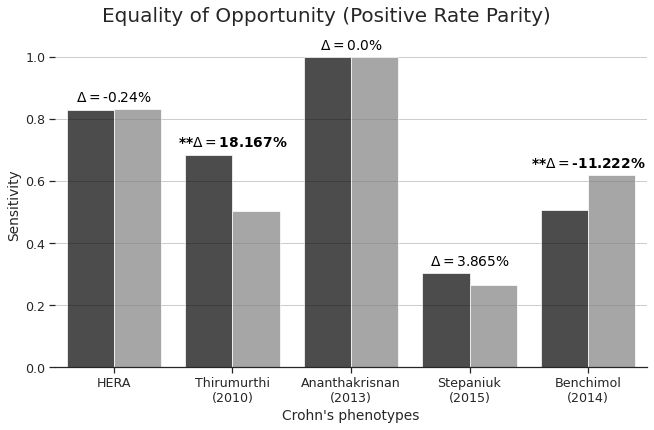

In [216]:
# #8700f9 women
# #00c4aa men
# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'Crohn\'s phenotypes': ["HERA", "Thirumurthi\n(2010)", "Ananthakrisnan\n(2013)", "Stepaniuk\n(2015)", "Benchimol\n(2014)"], 
                         'Black': [x[0] for x in all_vals_eqq_opp_race], 
                         'white': [x[1] for x in all_vals_eqq_opp_race]})

dfs1 = pd.melt(dfs, id_vars = "Crohn\'s phenotypes", var_name='race', value_name='Sensitivity')

white_silver = len(full_df[(full_df.race_source_concept_id == 4.0) & (full_df.person_id.isin(Y))].person_id.unique()) / len(full_df[full_df.race_source_concept_id == 4.0].person_id.unique())
black_silver = len(full_df[(full_df.race_source_concept_id == 3.0) & (full_df.person_id.isin(Y))].person_id.unique()) / len(full_df[full_df.race_source_concept_id == 3.0].person_id.unique())

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'Crohn\'s phenotypes', y='Sensitivity', 
               hue = 'race', data=dfs1, kind='bar', 
               palette=sns.color_palette(['black', 'grey']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(black_silver, xmin=0, xmax=3, linestyle = '--', color = 'black', label = 'black silver standard', alpha = 0.8)
# plt.axhline(white_silver, xmin=0, xmax=3, linestyle = '--', color = 'grey', label = 'white silver standard', alpha = 0.5)
# plt.axhline(1, xmin=0, xmax=3, linestyle = '-', color = 'black', label = 'silver standard', alpha = 0.5)
# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Equality of Opportunity (Positive Rate Parity)')

# plt.text(0, 1.025, "$\Delta = $" + str(np.round(diffs_eqq_opp_race[0] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(1, 1.025, "$\Delta = $" + str(np.round(diffs_eqq_opp_race[1] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(2, 0.05, "$\Delta = $" + str(np.round(diffs_eqq_opp_race[2] * 100, 3))  + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(3, 0.05, "$\Delta = $" + str(np.round(diffs_eqq_opp_race[3] * 100, 3))  + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(4, 0.05, "$\Delta = $" + str(np.round(diffs_eqq_opp_race[4] * 100, 3))  + '%', horizontalalignment='center', size='medium', color='black')

for i, ele in enumerate(all_vals_eqq_opp_race):
    part1 = "$\Delta = $" + str(np.round(diffs_eqq_opp_race[i] * 100, 3)) + '%'
    part2 = "$p = $" + str(np.round(pvals_eqq_opp_race[i], 4))
    full_str = part1 + '\n' + part2 
    if pvals_eqq_opp_race[i] < cutoff:
        plt.text(i, max(ele[0], ele[1]) + 0.025, '**' + part1, horizontalalignment='center', size='medium', color='black', weight='bold')
    else:
        plt.text(i, max(ele[0], ele[1]) + 0.025, part1, horizontalalignment='center', size='medium', color='black')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

plt.savefig('../png/crohns_equality_opportunity_race.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [217]:
# Again quoting the PAKDD lecture, predictive rate parity (or sufficiency) means that the true label
# is independent of the protected attribute conditional on the predicted outputs.

diffs_prp_race = []
all_vals_prp_race = []
pvals_prp_race = []

for phenotype in [demo_A, demo_B, demo_C, demo_D, demo_E]:
    class_0_prp = len(phenotype[(phenotype.race_source_concept_id == 4.0) & (phenotype.person_id.isin(Y))]) / len(phenotype[phenotype.race_source_concept_id == 4.0])
    class_1_prp = len(phenotype[(phenotype.race_source_concept_id == 3.0) & (phenotype.person_id.isin(Y))]) / len(phenotype[phenotype.race_source_concept_id == 3.0])
    diffs_prp_race.append(class_1_prp - class_0_prp)
    all_vals_prp_race.append((class_1_prp, class_0_prp))
    
    count = np.array([len(phenotype[(phenotype.race_source_concept_id == 4.0) & (phenotype.person_id.isin(Y))]), 
                      len(phenotype[(phenotype.race_source_concept_id == 3.0) & (phenotype.person_id.isin(Y))])])
    nobs = np.array([len(phenotype[phenotype.race_source_concept_id == 4.0]), len(phenotype[phenotype.race_source_concept_id == 3.0])])
    stat, pval = proportions_ztest(count, nobs)
    pvals_prp_race.append(pval)

pvals_prp_race = np.nan_to_num(pvals_prp_race, nan=1)

/home/tys2108/anaconda3/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:788: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std


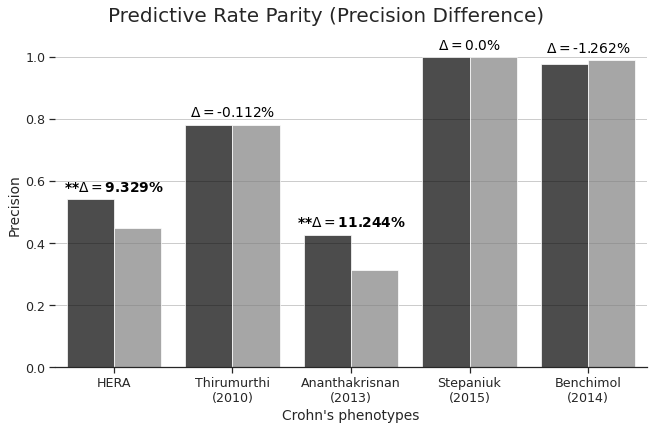

In [218]:
# #8700f9 women
# #00c4aa men
# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'Crohn\'s phenotypes': ["HERA", "Thirumurthi\n(2010)", "Ananthakrisnan\n(2013)", "Stepaniuk\n(2015)", "Benchimol\n(2014)"], 
                         'Black': [x[0] for x in all_vals_prp_race], 
                         'white': [x[1] for x in all_vals_prp_race]})

dfs1 = pd.melt(dfs, id_vars = "Crohn\'s phenotypes", var_name='race', value_name='Precision')

white_silver = len(full_df[(full_df.race_source_concept_id == 4.0) & (full_df.person_id.isin(Y))].person_id.unique()) / len(full_df[full_df.race_source_concept_id == 4.0].person_id.unique())
black_silver = len(full_df[(full_df.race_source_concept_id == 3.0) & (full_df.person_id.isin(Y))].person_id.unique()) / len(full_df[full_df.race_source_concept_id == 3.0].person_id.unique())

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'Crohn\'s phenotypes', y='Precision', 
               hue = 'race', data=dfs1, kind='bar', 
               palette=sns.color_palette(['black', 'grey']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(black_silver, xmin=0, xmax=3, linestyle = '--', color = 'black', label = 'Black silver standard')
# plt.axhline(white_silver, xmin=0, xmax=3, linestyle = '--', color = 'grey', label = 'white silver standard')
# plt.axhline(1, xmin=0, xmax=3, linestyle = '-', color = 'black', label = 'silver standard', alpha = 0.5)
# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Predictive Rate Parity (Precision Difference)')

# plt.text(0, 0.85, "$\Delta = $" + str(np.round(diffs_prp_race[0] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(1, 0.77, "$\Delta = $" + str(np.round(diffs_prp_race[1] * 100, 3)) + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(2, 0.65, "$\Delta = $" + str(np.round(diffs_prp_race[2] * 100, 3))  + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(3, 0.65, "$\Delta = $" + str(np.round(diffs_prp_race[3] * 100, 3))  + '%', horizontalalignment='center', size='medium', color='black')
# plt.text(4, 0.65, "$\Delta = $" + str(np.round(diffs_prp_race[4] * 100, 3))  + '%', horizontalalignment='center', size='medium', color='black')

for i, ele in enumerate(all_vals_prp_race):
    part1 = "$\Delta = $" + str(np.round(diffs_prp_race[i] * 100, 3)) + '%'
    part2 = "$p = $" + str(np.round(pvals_prp_race[i], 4))
    full_str = part1 + '\n' + part2 
    if pvals_prp_race[i] < cutoff:
        plt.text(i, max(ele[0], ele[1]) + 0.025, '**' + part1, horizontalalignment='center', size='medium', color='black', weight='bold')
    else:
        plt.text(i, max(ele[0], ele[1]) + 0.025, part1, horizontalalignment='center', size='medium', color='black')


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

plt.savefig('../png/crohns_pred_rate_parity_race.png', dpi=300, bbox_inches = 'tight')

handles, labels = plt.gca().get_legend_handles_labels()

# #specify order of items in legend
# order = [2,3,0,1]

# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)

# plt.savefig('../png/t2dm_pred_rate_parity_legend_race.png', dpi=300, bbox_inches = 'tight')

#labels=["women","men", "women silver standard", "men silver standard"])

plt.show()

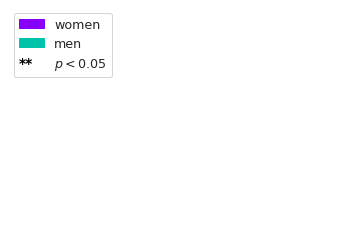

In [229]:
fig, ax = plt.subplots()
# ax.plot(range(10))

fig.patch.set_visible(False)
ax.axis('off')

# manually define a new patch 
# https://stackoverflow.com/questions/27174425/how-to-add-a-string-as-the-artist-in-matplotlib-legend
import matplotlib.text as mpl_text
import matplotlib.patches as mpatches

class AnyObject(object):
    def __init__(self, text, color):
        self.my_text = text
        self.my_color = color

class AnyObjectHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        print(orig_handle)
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpl_text.Text(x=0, y=0, text=orig_handle.my_text, color=orig_handle.my_color,
                                verticalalignment=u'baseline', weight='bold',
                                horizontalalignment=u'left', multialignment=None, 
                                fontproperties=None, rotation=0, linespacing=None, 
                                rotation_mode=None)
        handlebox.add_artist(patch)
        return patch

obj_0 = AnyObject("**", "black")
# obj_1 = AnyObject("B", "green")

patch1 = mpatches.Patch(color='#8700f9', label='women')
patch2 = mpatches.Patch(color='#00c4aa', label='men')


final = [handles[idx] for idx in order].append(obj_0)
other = [labels[idx] for idx in order].append('$p < 0.05$')

plt.legend([patch1, patch2, obj_0], ['women', 'men', '$p < 0.05$'],
           handler_map={obj_0:AnyObjectHandler()}, bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

plt.savefig('../png/legend_women_men.png', dpi=300, bbox_inches = 'tight')

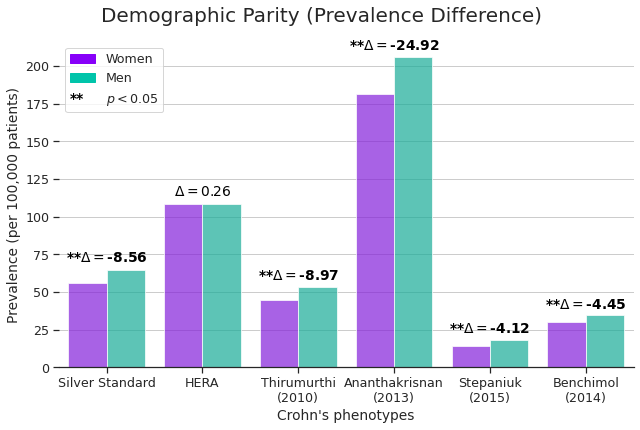

In [230]:
# #8700f9 women
# #00c4aa men

# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'Crohn\'s phenotypes': ["HERA", "Thirumurthi\n(2010)", "Ananthakrisnan\n(2013)", "Stepaniuk\n(2015)", "Benchimol\n(2014)"], 
                         'women': [x[0] * 100000 for x in all_vals_dp], 
                         'men': [x[1] * 100000 for x in all_vals_dp]})

dfs1 = pd.melt(dfs, id_vars = "Crohn\'s phenotypes", var_name='gender', value_name='Prevalence (per 100,000 patients)')

men_silver = len(full_df[full_df.gender_concept_id == 8507].person_id.unique()) / men_total * 100000
women_silver = len(full_df[full_df.gender_concept_id == 8532].person_id.unique()) / women_total * 100000

count = np.array([len(full_df[full_df.gender_concept_id == 8507].person_id.unique()), 
                  len(full_df[full_df.gender_concept_id == 8532].person_id.unique())])
nobs = np.array([men_total, women_total])
stat, pval_silver = proportions_ztest(count, nobs)


tmp = dfs1.append({'Crohn\'s phenotypes' : 'Silver Standard', 'gender' : 'women', 'Prevalence (per 100,000 patients)' : women_silver}, ignore_index=True)
tmp = tmp.append({'Crohn\'s phenotypes' : 'Silver Standard', 'gender' : 'men', 'Prevalence (per 100,000 patients)' : men_silver}, ignore_index=True)

category_order = ["Silver Standard", "HERA", "Thirumurthi\n(2010)", "Ananthakrisnan\n(2013)", "Stepaniuk\n(2015)", "Benchimol\n(2014)"]

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'Crohn\'s phenotypes', y='Prevalence (per 100,000 patients)', 
               hue = 'gender', data=tmp, kind='bar', order = category_order,
               palette=sns.color_palette(['#8700f9', '#00c4aa']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(women_silver, xmin=0, xmax=3, linestyle = '--', color = '#8700f9', label = 'silver standard (women)')
# plt.axhline(men_silver, xmin=0, xmax=3, linestyle = '--', color = '#00c4aa', label = 'silver standard (men)')

# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Demographic Parity (Prevalence Difference)')

if pval_silver < cutoff:
    plt.text(0, np.round(max(women_silver, men_silver), 0) + 5, "**$\Delta = $" + str(np.round(women_silver - men_silver, 2)), horizontalalignment='center', size='medium', color='black', weight='bold')
else:
    plt.text(0, np.round(max(women_silver, men_silver), 0) + 5, "$\Delta = $" + str(np.round(women_silver - men_silver, 2)), horizontalalignment='center', size='medium', color='black')
    
for i, ele in enumerate(all_vals_dp):
    part1 = "$\Delta = $" + str(np.round(diffs_dp[i] * 100000, 2))
    part2 = "$p = $" + str(np.round(pvals_dp[i], 4))
    full_str = part1 + '\n' + part2 
    if pvals_dp[i] < cutoff:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 5, '**' + part1, horizontalalignment='center', size='medium', color='black', weight='bold')
    else:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 5, part1, horizontalalignment='center', size='medium', color='black')
    # plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 5, , horizontalalignment='center', size='medium', color='black')

# plt.text(4, 70, "$\Delta = $" + str(np.round(women_silver - men_silver, 2)), horizontalalignment='center', size='medium', color='black')

# plt.text(0.03, all_vals_dp[0][1] * 100000, "]", horizontalalignment='center', size='medium', color='black', fontsize = 8)


# handles, labels = plt.gca().get_legend_handles_labels()

# #specify order of items in legend
# order = [2,3,0,1]

# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
#labels=["women","men", "women silver standard", "men silver standard"])

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

plt.legend([patch1, patch2, obj_0], ['Women', 'Men', '$p < 0.05$'],
           handler_map={obj_0:AnyObjectHandler()}, bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

plt.savefig('../png/crohns_demographic_parity_legend.png', dpi=300, bbox_inches = 'tight')
plt.show()
plt.close()


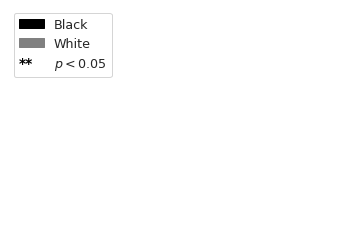

In [225]:
fig, ax = plt.subplots()
# ax.plot(range(10))

fig.patch.set_visible(False)
ax.axis('off')

# manually define a new patch 
# https://stackoverflow.com/questions/27174425/how-to-add-a-string-as-the-artist-in-matplotlib-legend
import matplotlib.text as mpl_text
import matplotlib.patches as mpatches

class AnyObject(object):
    def __init__(self, text, color):
        self.my_text = text
        self.my_color = color

class AnyObjectHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        print(orig_handle)
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpl_text.Text(x=0, y=0, text=orig_handle.my_text, color=orig_handle.my_color,
                                verticalalignment=u'baseline', weight='bold',
                                horizontalalignment=u'left', multialignment=None, 
                                fontproperties=None, rotation=0, linespacing=None, 
                                rotation_mode=None)
        handlebox.add_artist(patch)
        return patch

obj_0 = AnyObject("**", "black")
# obj_1 = AnyObject("B", "green")

patch1 = mpatches.Patch(color='black', label='Black')
patch2 = mpatches.Patch(color='grey', label='white')


final = [handles[idx] for idx in order].append(obj_0)
other = [labels[idx] for idx in order].append('$p < 0.05$')

plt.legend([patch1, patch2, obj_0], ['Black', 'White', '$p < 0.05$'],
           handler_map={obj_0:AnyObjectHandler()}, bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

plt.savefig('../png/legend_Black_white.png', dpi=300, bbox_inches = 'tight')

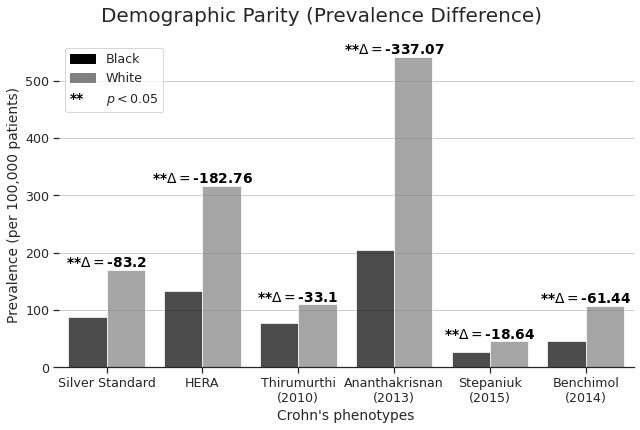

In [227]:
# #8700f9 women
# #00c4aa men
# https://stackoverflow.com/questions/52028043/side-by-side-barplot
dfs = pd.DataFrame(data={'Crohn\'s phenotypes': ["HERA", "Thirumurthi\n(2010)", "Ananthakrisnan\n(2013)", "Stepaniuk\n(2015)", "Benchimol\n(2014)"], 
                         'Black': [x[0] * 100000 for x in all_vals_dp_race], 
                         'white': [x[1] * 100000 for x in all_vals_dp_race]})

dfs1 = pd.melt(dfs, id_vars = "Crohn\'s phenotypes", var_name='race', value_name='Prevalence (per 100,000 patients)')

white_silver = len(full_df[full_df.race_source_concept_id == 4.0].person_id.unique()) / white_total * 100000
black_silver = len(full_df[full_df.race_source_concept_id == 3.0].person_id.unique()) / Black_total * 100000

count = np.array([len(full_df[full_df.race_source_concept_id == 4.0].person_id.unique()), 
                  len(full_df[full_df.race_source_concept_id == 3.0].person_id.unique())])
nobs = np.array([white_total, Black_total])
stat, pval_silver = proportions_ztest(count, nobs)


tmp = dfs1.append({'Crohn\'s phenotypes' : 'Silver Standard', 'race' : 'Black', 'Prevalence (per 100,000 patients)' : black_silver}, ignore_index=True)
tmp = tmp.append({'Crohn\'s phenotypes' : 'Silver Standard', 'race' : 'white', 'Prevalence (per 100,000 patients)' : white_silver}, ignore_index=True)

category_order = ["Silver Standard", "HERA", "Thirumurthi\n(2010)", "Ananthakrisnan\n(2013)", "Stepaniuk\n(2015)", "Benchimol\n(2014)"]

sns.set(style = "ticks", font_scale = 1.15)
g = sns.catplot(x = 'Crohn\'s phenotypes', y='Prevalence (per 100,000 patients)', 
               hue = 'race', data=tmp, kind='bar', order = category_order,
               palette=sns.color_palette(['black', 'grey']), alpha = 0.7, legend=False)
sns.despine(left=True)

plt.grid(axis='y')
# plt.axhline(black_silver, xmin=0, xmax=3, linestyle = '--', color = 'black', label = 'silver standard (Black)')
# plt.axhline(white_silver, xmin=0, xmax=3, linestyle = '--', color = 'grey', label = 'silver standard (white)')

# plt.legend()

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Demographic Parity (Prevalence Difference)')


# plt.text(0, 320, "$\Delta = $" + str(np.round(diffs_dp_race[0] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(1, 110, "$\Delta = $" + str(np.round(diffs_dp_race[1] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(2, 575, "$\Delta = $" + str(np.round(diffs_dp_race[2] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(3, 75, "$\Delta = $" + str(np.round(diffs_dp_race[3] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(4, 105, "$\Delta = $" + str(np.round(diffs_dp_race[4] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# plt.text(4, 200, "$\Delta = $" + str(np.round(black_silver - white_silver, 2)), horizontalalignment='center', size='medium', color='black')

# plt.text(0.03, all_vals_dp[0][1] * 100000, "]", horizontalalignment='center', size='medium', color='black', fontsize = 8)


# handles, labels = plt.gca().get_legend_handles_labels()

# #specify order of items in legend
# order = [2,3,0,1]

# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
#labels=["women","men", "women silver standard", "men silver standard"])

if pval_silver < cutoff:
    plt.text(0, np.round(max(black_silver, white_silver), 0) + 5, "**$\Delta = $" + str(np.round(black_silver - white_silver, 2)), horizontalalignment='center', size='medium', color='black', weight='bold')
else:
    plt.text(0, np.round(max(black_silver, white_silver), 0) + 5, "$\Delta = $" + str(np.round(black_silver - white_silver, 2)), horizontalalignment='center', size='medium', color='black')
    
for i, ele in enumerate(all_vals_dp_race):
    part1 = "$\Delta = $" + str(np.round(diffs_dp_race[i] * 100000, 2))
    part2 = "$p = $" + str(np.round(p_vals_dp_race[i], 4))
    full_str = part1 + '\n' + part2 
    if p_vals_dp_race[i] < cutoff:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 5, '**' + part1, horizontalalignment='center', size='medium', color='black', weight='bold')
    else:
        plt.text(i + 1, np.round(max(ele[0], ele[1]) * 100000, 0) + 5, part1, horizontalalignment='center', size='medium', color='black')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

plt.legend([patch1, patch2, obj_0], ['Black', 'White', '$p < 0.05$'],
           handler_map={obj_0:AnyObjectHandler()}, bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

plt.savefig('../png/crohns_demographic_parity_race_legend.png', dpi=300, bbox_inches = 'tight')
plt.show()


In [243]:
# # #8700f9 women
# # #00c4aa men
# # https://stackoverflow.com/questions/52028043/side-by-side-barplot

# fig, axes = plt.subplots(1, 3, sharex=True, figsize=(16,8))
# fig.suptitle('1 row x 3 columns axes with no data')


# dfs_dp = pd.DataFrame(data={'T2DM phenotypes': ['Miller', 'LEGEND', 'PheKB'], 
#                          'women': [x[0] * 100000 for x in all_vals_dp], 
#                          'men': [x[1] * 100000 for x in all_vals_dp]})

# dfs1_dp = pd.melt(dfs_dp, id_vars = "T2DM phenotypes", var_name='gender', value_name='Prevalence (per 100,000 patients)')

# dfs_opp = pd.DataFrame(data={'T2DM phenotypes': ['Miller', 'LEGEND', 'PheKB'], 
#                          'women': [x[0] for x in all_vals_eqq_opp], 
#                          'men': [x[1] for x in all_vals_eqq_opp]})

# dfs1_opp = pd.melt(dfs, id_vars = "T2DM phenotypes", var_name='gender', value_name='Sensitivity')

# dfs_prp = pd.DataFrame(data={'T2DM phenotypes': ['Miller', 'LEGEND', 'PheKB'], 
#                          'women': [x[0] for x in all_vals_prp], 
#                          'men': [x[1] for x in all_vals_prp]})

# dfs1_prp = pd.melt(dfs_prp, id_vars = "T2DM phenotypes", var_name='gender', value_name='Precision')


# men_silver_dp = len(full_df[full_df.gender_concept_id == 8507].subject_id.unique()) / men_total * 100000
# women_silver_dp = len(full_df[full_df.gender_concept_id == 8532].subject_id.unique()) / women_total * 100000

# men_silver_opp = len(full_df[(full_df.gender_concept_id == 8507) & (full_df.person_id.isin(Y))].subject_id.unique()) / len(full_df[full_df.gender_concept_id == 8507].subject_id.unique())
# women_silver_opp = len(full_df[(full_df.gender_concept_id == 8532) & (full_df.person_id.isin(Y))].subject_id.unique()) / len(full_df[full_df.gender_concept_id == 8532].subject_id.unique())

# men_silver_prp = len(full_df[(full_df.gender_concept_id == 8507) & (full_df.person_id.isin(Y))].subject_id.unique()) / len(full_df[full_df.gender_concept_id == 8507].subject_id.unique())
# women_silver_prp = len(full_df[(full_df.gender_concept_id == 8532) & (full_df.person_id.isin(Y))].subject_id.unique()) / len(full_df[full_df.gender_concept_id == 8532].subject_id.unique())


# sns.set(style = "ticks")
# g = sns.catplot(ax=axes[0], x = 'T2DM phenotypes', y='Prevalence (per 100,000 patients)', 
#                hue = 'gender', data=dfs1_dp, kind='bar', 
#                palette=sns.color_palette(['#8700f9', '#00c4aa']), alpha = 0.7)

# g = sns.catplot(ax=axes[1], x = 'T2DM phenotypes', y='Sensitivity', 
#                hue = 'gender', data=dfs1_opp, kind='bar', 
#                palette=sns.color_palette(['#8700f9', '#00c4aa']), alpha = 0.7)

# g = sns.catplot(ax=axes[2], x = 'T2DM phenotypes', y='Precision', 
#                hue = 'gender', data=dfs1_prp, kind='bar', 
#                palette=sns.color_palette(['#8700f9', '#00c4aa']), alpha = 0.7)


# sns.despine()

# plt.grid(axis='y')

# for i, ele in enumerate([(women_silver_dp, men_silver_dp), (women_silver_opp, men_silver_opp), (women_silver_prp, men_silver_prp)]):
#     axes[i].axhline(ele[0], xmin=0, xmax=3, linestyle = '--', color = '#8700f9', label = 'silver standard (women)')
#     axes[i].axhline(ele[1], xmin=0, xmax=3, linestyle = '--', color = '#00c4aa', label = 'silver standard (men)')

# # axes[0].axhline(women_silver, xmin=0, xmax=3, linestyle = '--', color = '#8700f9', label = 'silver standard (women)')
# # axes[0].axhline(men_silver, xmin=0, xmax=3, linestyle = '--', color = '#00c4aa', label = 'silver standard (men)')

# # plt.legend()

# # g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
# # g.fig.suptitle('Demographic Parity (Prevalence Difference)')


# axes[0].text(0, 1910, "$\Delta = $" + str(np.round(diffs_dp[0] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# axes[0].text(1, 2075, "$\Delta = $" + str(np.round(diffs_dp[1] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# axes[0].text(2, 125, "$\Delta = $" + str(np.round(diffs_dp[2] * 100000, 2)), horizontalalignment='center', size='medium', color='black')
# axes[0].text(2, 1650, "$\Delta = $" + str(np.round(women_silver - men_silver, 2)), horizontalalignment='center', size='medium', color='black')

# # plt.text(0.03, all_vals_dp[0][1] * 100000, "]", horizontalalignment='center', size='medium', color='black', fontsize = 8)


# # handles, labels = plt.gca().get_legend_handles_labels()

# #specify order of items in legend
# # order = [2,3,0,1]

# # plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
# #labels=["women","men", "women silver standard", "men silver standard"])

# # plt.savefig('../png/t2dm_demographic_parity.png', dpi=300, bbox_inches = 'tight')
# plt.show()


In [123]:
# race_source_value == WHITE
# race_source_concept_id == 4.0 [8527]

# VS

# race_source_value == BLACK OR AFRICAN AMERICAN
# race_source_concept_id == 3.0 [8516]

names = ["HERA", "Thirumurthi (2010)", "Ananthakrisnan (2013)", "Stepaniuk (2015)", "Benchimol (2014)"]

for i, phenotype in enumerate([demo_A, demo_B, demo_C, demo_D, demo_E]):
    print('i:' + names[i])
    print('nwomen: ' + str(len(phenotype[phenotype.gender_concept_id == 8532].person_id.unique())))
    print('nmen: ' + str(len(phenotype[phenotype.gender_concept_id == 8507].person_id.unique())))
    print('nblack: ' + str(len(phenotype[phenotype.race_source_concept_id == 3.0].person_id.unique())))
    print('nwhite: ' + str(len(phenotype[phenotype.race_source_concept_id == 4.0].person_id.unique())))

i:HERA
nwomen: 4085
nmen: 3222
nblack: 510
nwhite: 3387
i:Thirumurthi (2010)
nwomen: 1670
nmen: 1587
nblack: 292
nwhite: 1174
i:Ananthakrisnan (2013)
nwomen: 6809
nmen: 6124
nblack: 779
nwhite: 5793
i:Stepaniuk (2015)
nwomen: 532
nmen: 543
nblack: 101
nwhite: 483
i:Benchimol (2014)
nwomen: 1129
nmen: 1025
nblack: 173
nwhite: 1143


In [126]:
from datetime import datetime
from time import time

In [193]:
# race_source_value == WHITE
# race_source_concept_id == 4.0 [8527]

# VS

# race_source_value == BLACK OR AFRICAN AMERICAN
# race_source_concept_id == 3.0 [8516]

names = ["HERA", "Thirumurthi (2010)", "Ananthakrisnan (2013)", "Stepaniuk (2015)", "Benchimol (2014)"]

for i, phenotype in enumerate([demo_A, demo_B, demo_C, demo_D, demo_E]):
    print('i:' + names[i])
    births = phenotype.birth_datetime
    ages = []
    for ele in births:
        age = np.datetime64(datetime.now()) - np.datetime64(ele)
        age = age.astype('timedelta64[Y]')
        age_int = age / np.timedelta64(1, 'Y')
        ages.append(age_int)
    
    tot = len(ages)
    print(np.round(len([x for x in ages if x <= 18]) / tot * 100, 2))
    print(np.round(len([x for x in ages if x > 18 and x <=30]) / tot * 100, 2)) 
    print(np.round(len([x for x in ages if x > 30 and x <=60]) / tot * 100, 2)) 
    print(np.round(len([x for x in ages if x > 60 and x <=80]) / tot * 100, 2))
    print(np.round(len([x for x in ages if x >= 80]) / tot * 100, 2))
#     print('nwomen: ' + str(len(phenotype[phenotype.gender_concept_id == 8532].person_id.unique())))
#     print('nmen: ' + str(len(phenotype[phenotype.gender_concept_id == 8507].person_id.unique())))
#     print('nblack: ' + str(len(phenotype[phenotype.race_source_concept_id == 3.0].person_id.unique())))
#     print('nwhite: ' + str(len(phenotype[phenotype.race_source_concept_id == 4.0].person_id.unique())))

i:HERA
3.85
12.55
37.26
28.3
19.02
i:Thirumurthi (2010)
0.03
6.42
38.78
27.72
27.97
i:Ananthakrisnan (2013)
3.97
14.46
42.27
24.84
15.2
i:Stepaniuk (2015)
0.0
9.86
53.86
18.33
18.51
i:Benchimol (2014)
6.69
21.68
40.2
23.17
8.82
